In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### TODO:
- Use the FLD data field tag to break string from field
- Remove long digit by xdig

In [2]:
from fastai.text import *
import html
import pandas as pd
import json
from requests import Session
MATIFY_API_EP = 'http://matify.net:8000/'
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag
NUM = 'xdig'  # Number

In [3]:
PATH=Path('data/matify/')
PATH.mkdir(exist_ok=True)
PROD_FILE = PATH/'text'/'matify_product.csv'
CLAS_PATH = PATH/'classifier'
CLAS_PATH.mkdir(exist_ok=True)
LM_PATH=PATH/'language_model'
LM_PATH.mkdir(exist_ok=True)
W2V_PATH=PATH/'w2v'
W2V_PATH.mkdir(exist_ok=True)
W2V_FILE=W2V_PATH/'fasttext.no.pickle'

In [4]:
from niklib.w2v_model import Word2VecModel
w2v = Word2VecModel.from_pickle(W2V_FILE)

In [5]:
def get_SubCategories ():
    session = Session()
    categoryResponse = session.get(MATIFY_API_EP + 'listCategories/', 
                                   headers={'Accept':'application/json'})
    assert (int(categoryResponse.status_code) == 200), \
            "Error when requesting all categories. Response text: " + categoryResponse.text
    categories = json.loads(categoryResponse.text)
    for category in categories:
        for subCategory in category['sub_categories']:
            yield (subCategory['id'], subCategory['name'])

id2subcat = {id: subcat for id, subcat in get_SubCategories()}
id2subcat[142] = 'NotFood'
# id2subcat[-1] = 'NoLabel'

In [6]:
df_full = pd.read_csv(PROD_FILE)

In [7]:
df_full

,id,name,initial_price,category_id,store_id,description,discount_rate,from_date,image,price,to_date,image_url,ts,status,image_aspect_ratio
0,2,Coop Grill Perfekt Bratwurst,34.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-18 17:08:11,2,NaN
1,3,Lofoten krabbeskjell,49.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-18 17:08:11,2,NaN
2,4,Fjordland,NaN,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-18 17:08:11,2,NaN
3,7,Blue berry,119.2,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-18 17:08:11,2,NaN
4,10,Raspberry,119.2,77.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-18 17:08:11,2,NaN
5,11,Coop juice,22.4,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-06-18 17:08:11,2,NaN
6,16,Norsk blomkål,NaN,78.0,5.0,Blomkålprisen gjelder uke 33,NaN,2016-08-14,NaN,9.9,2016-08-21,https://akamai.shopgun.com/img/offer/crop/thum...,2017-06-18 17:08:11,2,NaN
7,17,Kyllingkjøttdeig,NaN,94.0,5.0,"400 g First Price, pr. kg 44,25",NaN,2016-08-14,NaN,17.7,2016-08-21,https://akamai.shopgun.com/img/offer/crop/thum...,2017-06-18 17:08:11,2,NaN
8,18,Strimlet svinekjøtt,NaN,93.0,5.0,"350 g Folkets, pr. kg 66,86",NaN,2016-08-14,NaN,23.4,2016-08-21,https://akamai.shopgun.com/img/offer/crop/thum...,2017-06-18 17:08:11,2,NaN
9,19,Karbonadedeig,NaN,92.0,5.0,"400 g Folkets, uten tilsatt salt og vann, pr. ...",NaN,2016-08-14,NaN,55.9,2016-08-21,https://akamai.shopgun.com/img/offer/crop/thum...,2016-11-27 15:26:51,2,NaN


In [29]:
# Process df to create df with only texts and labels column
df = pd.DataFrame()
df["texts"]= df_full["store_id"].astype("str") + "_store " + df_full["name"] + " " + df_full["description"]
df["labels"] = df_full["category_id"]
df = df[["labels", "texts"]]
df = df[~pd.isna(df["texts"])] # remove no text
df["labels"].fillna(-1, inplace=True) # -1 for no label
df = df[df['labels'].isin(list(id2subcat.keys()) + [-1])] # only keep valid label, including no label
df.reset_index(inplace=True, drop=True)

In [30]:
# shuffle
np.random.seed(42)
idx = np.random.permutation(len(df))
df = df.iloc[idx]
df_w_labels = df[df["labels"]!=-1]

In [31]:
# Split label data
df_trn, df_val = sklearn.model_selection.train_test_split(df_w_labels, test_size=0.2, stratify=df_w_labels["labels"])
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_val.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

In [32]:
classes = pd.DataFrame(list(id2subcat.items()), columns=['id', 'subcat'])
classes.to_csv(CLAS_PATH/'classes.csv', header=False, index=False)

In [33]:
# This is all texts so we can build language model
texts = df["texts"].as_matrix()
labels = df["labels"].as_matrix()

In [34]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
                        texts, test_size=0.1)

In [35]:
np.random.seed(42)
idx = np.random.permutation(len(texts))
texts = texts[idx]
labels = labels[idx]

In [36]:
len(trn_texts), len(val_texts)

(27315, 3035)

In [37]:
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

### Tokenize

In [38]:
chunksize=24000

In [39]:
def split_by_popularity(word, w2v):
    unknown_pop_score = w2v.n_vocabs
    if w2v.word2idx(word) > 0:
        return w2v.word2idx(word), [word]
        
    if (word.replace('.','',1).replace(',','',1).isdigit()) and len(word)>1 : #all numbers replaced by xdig. except single digit
        # return unknown_pop_score, [word] # Don't care about digit
        return unknown_pop_score, [f'{NUM}']

    if len(word)<=5:
        return unknown_pop_score, [word]


    best_pop_score = unknown_pop_score
    best_split = None
    best_nsplit = 3 # Max split to split
    for i_cut in range(len(word)-2, 1, -1):
        prefix, core = word[:i_cut], word[i_cut:]

        if w2v.word2idx(core) < 0:
            continue
        core_score = w2v.word2idx(core)

        if w2v.word2idx(prefix) < 0:
            prefix_score, prefix = split_by_popularity(prefix, w2v)
        else:
            prefix_score, prefix = w2v.word2idx(prefix), [prefix]                
        if (prefix_score >= unknown_pop_score): # Don't split if all splitted words are good
            continue
        pop_score = prefix_score + core_score
        words = prefix; words.append(core)

        if len(words) > best_nsplit: continue # Don't split more than best_nsplit
        if (len(words) < best_nsplit) or (pop_score < best_pop_score):
            #print(prefix, prefix_score, core_score, pop_score)
            best_split = words
            best_nsplit= len(words)
            best_pop_score = pop_score

    if best_split is None:
        return (unknown_pop_score, [word])
    else:
        return (best_pop_score, best_split)

In [40]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [41]:
def get_texts(df, w2v, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)

    alltoks = Tokenizer().proc_all_mp(partition_by_cores(texts)) # Note: apply our split_by_popularity algorithm
    alltoks = [[split_by_popularity(tok, w2v)[1] for tok in toks] for toks in alltoks]
    alltoks = [[newtok for newtoks in toks for newtok in newtoks] for toks in alltoks] # flatten list
    return alltoks, list(labels)

In [42]:
def get_all(df, w2v, n_lbls): # Used when df is chunked
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, w2v, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [43]:
df_trn = pd.read_csv(LM_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH/'test.csv', header=None, chunksize=chunksize)

In [44]:
# !python -m spacy download en

In [45]:
tok_trn, trn_labels = get_all(df_trn, w2v, 1)
tok_val, val_labels = get_all(df_val, w2v, 1)

0
1
0


In [46]:
tok_trn

[['\n',
  'xbos',
  'xfld',
  '1',
  '15.0_store',
  'mør',
  'brad',
  'biff',
  'av',
  'storfe',
  ',',
  'i',
  'bit',
  ',',
  'frossent',
  ',',
  'import',
  ',',
  'pr',
  'hg',
  '.',
  'xdig',
  '/',
  'kg',
  '.',
  't_up',
  'kroners',
  '.',
  'marked',
  'marked'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  '4.0_store',
  'toro',
  'sauser',
  'stort',
  'utvalg',
  '.',
  'fra',
  'xdig',
  'g',
  '1',
  'pk',
  'fra',
  'xdig'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  '5.0_store',
  'lakse',
  'filet',
  'pr',
  '.',
  'kg',
  'xdig'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  '14.0_store',
  'polar',
  'seafood',
  'reker',
  'fryst',
  '.',
  'xdig',
  '/',
  'xdig',
  '.',
  'pr',
  'kg'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  '15.0_store',
  'jif',
  'spray',
  'kjøkken',
  '/',
  'baderom',
  '/',
  'universal',
  ',',
  '500ml',
  ',',
  'lilleborg',
  '.',
  'xdig',
  '/',
  'l'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  '10.0_store',
  'dream',
  'ies',
  'laks',
  ',',
  'xdig',


In [47]:
(LM_PATH/'tmp').mkdir(exist_ok=True)

In [48]:
np.save(LM_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val.npy', tok_val)

In [49]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('xdig', 49458),
 ('1', 29773),
 ('\n', 27315),
 ('xbos', 27315),
 ('xfld', 27315),
 ('.', 26668),
 (',', 18581),
 ('kg', 18034),
 ('pr', 16016),
 ('/', 15789),
 ('g', 10195),
 ('fra', 7602),
 ('g.', 7049),
 ('t_up', 5547),
 ('15.0_store', 5479),
 ('14.0_store', 4845),
 ('coop', 3595),
 ('pk', 3495),
 ('8.0_store', 3337),
 ('-', 3023),
 ('l', 2818),
 ('6.0_store', 2651),
 ('7.0_store', 2387),
 ('og', 2091),
 ('stk', 2046)]

In [50]:
max_vocab = 150000
min_freq = 1

In [51]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [52]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

4937

In [53]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [54]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [55]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos)})

### Merge itos and stoi with Fasttext vocab and embedding


In [56]:
em_sz = 300
# Get itos2 and stoi2 of the W2V dict
itos2 = w2v.idx2word
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

# 1. Build vocab and emb for the first vocabs
row_m = w2v.idx2emb.mean(0)
new_w = np.zeros((max_vocab, em_sz), dtype=np.float32)
for i, w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = w2v.idx2emb[r] if r>=0 else row_m
    
# 2. Get the rest from the second vocab
idx = len(itos)
for i, w in enumerate(itos2):
    if stoi[w] < 0:
        itos.append(w)
        stoi[w] = idx
        new_w[idx] = w2v.idx2emb[i]
        idx += 1
    if idx >= max_vocab: break

pickle.dump(itos, open(LM_PATH/'tmp'/'itos_full.pkl', 'wb'))
itos = pickle.load(open(LM_PATH/'tmp'/'itos_full.pkl', 'rb'))

### Build language model

In [57]:
em_sz, nh, nl = 300,600,1
vs=len(itos)

In [58]:
wd=1e-7
bptt=50 # instead of 70 bptt in fasttext
bs=32
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [59]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7


In [60]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [61]:
wgts = learner.model.state_dict()
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))
learner.model.load_state_dict(wgts)

In [62]:
lr=1e-3
lrs = lr

In [63]:
learner.fit(lrs/2, 2, wds=wd, use_clr=(32,2), cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      10.37539   10.139148  0.035829  
    1      7.936309   7.600059   0.053392                   
    2      5.74324    5.473402   0.119904                   



[array([5.4734]), 0.11990407619812934]

In [64]:
learner.save('lm_last_ft')
learner.load('lm_last_ft')
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      1.956519   1.684154   0.652433  



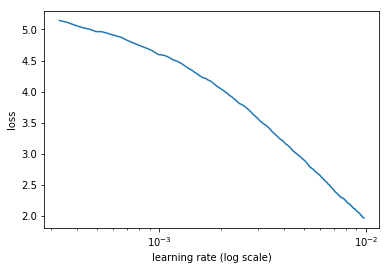

In [65]:
learner.sched.plot()

In [66]:
learner.fit(0.01/2, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.311045   1.976123   0.608282  
    1      1.53661    1.387152   0.702338                   
    2      1.24691    1.186237   0.746108                   
    3      1.10089    1.110593   0.75963                    
    4      1.01464    1.066899   0.771774                   
    5      0.963547   1.031783   0.776552                    
 16%|█▌        | 48/303 [00:04<00:24, 10.57it/s, loss=0.965]

KeyboardInterrupt: 

In [67]:
learner.save('lm1')
learner.save_encoder('lm1_enc')

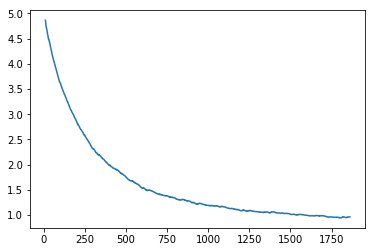

In [68]:
learner.sched.plot_loss()

### Train classifier

In [69]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=24000)
df_val = pd.read_csv(CLAS_PATH/'test.csv', header=None, chunksize=24000)
tok_trn, trn_labels = get_all(df_trn, w2v, 1)
tok_val, val_labels = get_all(df_val, w2v, 1)

0




0






In [70]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)
id2subcatid = list(np.unique(trn_labels))
pickle.dump(id2subcatid, open(CLAS_PATH/'id2subcatid.pkl', 'wb'))


In [71]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [72]:
itos = pickle.load((LM_PATH/'tmp'/'itos_full.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

150000

In [73]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [74]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))
id2subcatid = pickle.load(open(CLAS_PATH/'id2subcatid.pkl', 'rb'))
subcatid2id = {v:k for k, v in enumerate(id2subcatid)}
trn_labels = np.array([ subcatid2id[label] for label in trn_labels ])
val_labels = np.array([ subcatid2id[label] for label in val_labels ])

In [75]:
bptt,em_sz,nh,nl = 50,300,600,1
c = len(id2subcatid)
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [76]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

 16%|█▌        | 48/303 [00:20<01:46,  2.40it/s, loss=0.965]

In [77]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])# * 0.5
# dps = np.array([0.2]*5)
m = get_rnn_classifer(bptt, 20*bptt, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 1000, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [78]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])
#lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-3])
lrs = 1e-3
wd = 1e-7
# wd = 0
learn.load_encoder('lm1_enc')

In [79]:
len(learn.models.get_layer_groups())

3

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

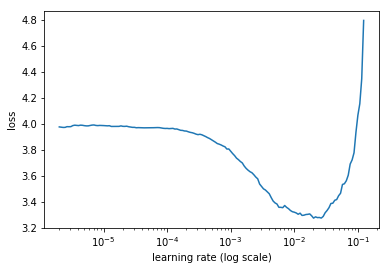

In [80]:
learn.freeze_to(-1)
learn.lr_find(lrs/1000)
learn.sched.plot()

In [81]:
learn.fit(0.01, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      2.080286   1.221924   0.663471  


[array([1.22192]), 0.6634711897891501]

In [82]:
learn.save('clas_0')
learn.load('clas_0')
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

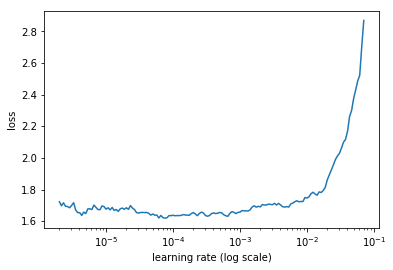

In [83]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [84]:
learn.fit(1e-3, 20, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=20), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      1.534811   0.996415   0.72754   
    1      1.35407    0.906839   0.757493                    
    2      1.212056   0.818547   0.7889                      
 87%|████████▋ | 202/231 [00:01<00:00, 155.62it/s, loss=1.11]

Exception in thread Thread-16:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



    3      1.10073    0.755771   0.807254                    
    4      1.024574   0.709604   0.828314                     
    5      0.934063   0.658905   0.846492                     
    6      0.846508   0.627347   0.850984                     
    7      0.769183   0.615301   0.856745                     
    8      0.735182   0.602973   0.859318                     
    9      0.696192   0.596602   0.861166                     
    10     0.721492   0.580311   0.869488                     
    11     0.680882   0.573618   0.875948                     
    12     0.605371   0.574919   0.86909                      
    13     0.574727   0.551099   0.869318                     
    14     0.526276   0.571032   0.875053                     
    15     0.526409   0.548867   0.872097                     
    16     0.558065   0.535755   0.883753                     
    17     0.487072   0.545289   0.880974                     
    18     0.503269   0.527582   0.88043                

[array([0.52522]), 0.8839810843053071]

In [85]:
learn.save('clas_1')
learn.load('clas_1')
learn.unfreeze()

In [86]:
learn.lr_find(lrs/1000)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 65%|██████▍   | 150/231 [00:02<00:01, 52.10it/s, loss=1.65] 


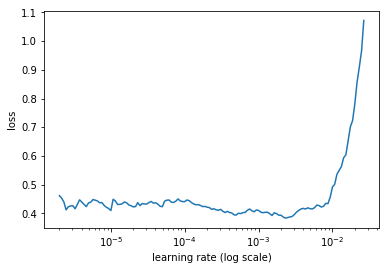

In [87]:
learn.sched.plot()

In [89]:
learn.fit(lrs, 2, wds=wd, cycle_len=14, use_clr=(32,10), cycle_mult=1)
# learn.fit(1e-3, 50, wds=wd, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.124002   0.688159   0.892666  
    1      0.174772   0.673522   0.900202                    
    2      0.166313   0.694657   0.893013                    
    3      0.15991    0.663052   0.898738                    
    4      0.14275    0.681683   0.895513                    
    5      0.212573   0.673213   0.900528                    
    6      0.174826   0.671872   0.898536                    
    7      0.162528   0.690858   0.896652                    
    8      0.142347   0.723945   0.894876                    
    9      0.153268   0.679977   0.901253                    
    10     0.135434   0.662499   0.900228                    
    11     0.122137   0.659693   0.901688                    
    12     0.137595   0.697321   0.899416                    
    13     0.114929   0.678327   0.895503                    
    14     0.132705   0.684718   0.896833                     
    15     0.126156   0.6

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('clas_final')

### Reload model

In [ ]:
# USE_GPU = False
itos = pickle.load((LM_PATH/'tmp'/'itos_full.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
classes = pd.read_csv(CLAS_PATH/'classes.csv', header=None)
id2subcatid = pickle.load(open(CLAS_PATH/'id2subcatid.pkl', 'rb'))

bptt,em_sz,nh,nl = 40,300,600,1
c = len(id2subcatid)
vs = len(itos)
bs = 48

m = get_rnn_classifer(bptt, 20*bptt, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 1000, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])
load_model(m, PATH/'models'/'clas_final.h5')
m = to_gpu(m)

In [ ]:
df_test = pd.DataFrame(data=[[0, 'Street food grillfakkel Grill perfekt. 200 g. Pr kg 249,50'],
                   [0, 'Hatting pølsebrød'],
                   [0, 'Street food baby back ribs Grill perfekt. 800 g. Pr kg 186,25'],
                   [0, 'Santa maria bbq sauce 3 varianter. 420-470 g. Pr kg fra 63,62'],
                   [0, 'Grill perfekt kyllingfilet Tex. BBQ. 400 g. Pr kg 174,75'],
                   [0, 'Street food kyllingspyd Grill perfekt. Thai eller BBQ. 180 g. Pr kg 221,67'],
                   [0, 'Grill perfekt flintstek Krydret. Pr kg'],
                   [0, 'Coop gresk landbrød Butikkstekt. 560 g. Pr kg 44,46'],
                   [0, 'Coop fiber & frøbrød 650 g. Pr kg 30,62']]) # always put labels first and data field later

In [ ]:
tok_test, test_labels = get_texts(df_test, w2v, 1)
test_clas = np.array([[stoi[o] for o in p] for p in tok_test])

In [ ]:
tok_test

In [ ]:
test_ds = TextDataset(test_clas, test_labels)
test_dl = DataLoader(test_ds, batch_size=100, transpose=True, num_workers=1, pad_idx=1)

In [ ]:
m.reset()

In [ ]:
test_clas

In [ ]:
m.eval()
for x, y in test_dl:
    output = to_np(m(V(x)))[0] # Only get the final prediction, no hidden states
    preds = np.argmax(output, axis=1)

In [ ]:
preds = [id2subcatid[id] for id in preds]

In [ ]:
subcatid2name ={item[0]:item[1] for idx, item in classes.iterrows()}

In [ ]:
preds_subcat = [subcatid2name[id] for id in preds]

In [ ]:
preds_subcat

In [ ]:
preds